# <div align="center">SDP - Systèmes de décision</div>

### <div align="center">01-02-2025</div>

- Kiyoshi Araki

- GabrielSouza

- Lucas Tramonte


## Libraries

In [35]:
import numpy as np
import pandas as pd 
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
import random
%matplotlib inline
from gurobipy import *

## Data processing

In [36]:
number_of_bricks = 22
number_of_sr = 4

# Current Structure of Sales Territories :
sr_assignments_current = [(1, 4,  [4, 5, 6, 7, 8, 15]),
          (2, 14, [10, 11, 12, 13, 14]),
          (3, 16, [9, 16, 17, 18]),
          (4, 22, [1, 2, 3, 19, 20, 21, 22])    
         ]

In [37]:
bricks_index_values_file = "Assets/Data/bricks_index_values.csv"

# brick_workloads : dict[int : float] : associates a brick identifier j with its new index value v_j.
brick_workloads = dict()

# Loading data
with open(bricks_index_values_file) as bricksIndexValuesFile:
    reader = csv.DictReader(bricksIndexValuesFile)
    for row in reader:
        b = int(row['brick'])
        brick_workloads[b] = float(row['index_value'])
        
brick_rp_distances_file = "Assets/Data/brick_rp_distances.csv"

# distance_sr_brick : dict[(int, int) : float] : associates with the pair (i, j) of RP and brick identifiers, the distance separating i's office from the j brick
distance_sr_brick = dict()

# Loading data
with open(brick_rp_distances_file) as brickRpDistancesFile:
    reader = csv.DictReader(brickRpDistancesFile)
    for row in reader:
        b = int(row['brick'])
        for rpId in range(1, number_of_sr + 1):
            distance_sr_brick[(rpId, b)] = float(row[f'rp{rpId}'])

In [38]:
SR_set = set()
Center_Brick_Set = set()
Brick_List = list()

for rp, center_brick, bricks_assigned in sr_assignments_current:
    print(f'SR {rp}', f'Center Brick {center_brick}', f'Bricks assigned', *bricks_assigned)
    SR_set.add(rp)
    Center_Brick_Set.add(center_brick)
    Brick_List += bricks_assigned

Brick_List.sort()
assert Brick_List == list(range(1, number_of_bricks + 1))
assert Center_Brick_Set - set(Brick_List) == set()
assert SR_set == set(range(1, number_of_sr + 1))

SR 1 Center Brick 4 Bricks assigned 4 5 6 7 8 15
SR 2 Center Brick 14 Bricks assigned 10 11 12 13 14
SR 3 Center Brick 16 Bricks assigned 9 16 17 18
SR 4 Center Brick 22 Bricks assigned 1 2 3 19 20 21 22


In [39]:
assert brick_workloads[4] == 0.1516
assert brick_workloads[22] == 0.2531
assert distance_sr_brick[(1, 1)] == 16.16
assert distance_sr_brick[(2, 15)] == 2.32
assert distance_sr_brick[(3, 16)] == 0.00

# Step 1

## **Exercise**: 
Formulate and implement two mono-objective linear optimization models to solve the assignment problem using a distance and a disruption objective. Solve the instance with 22 Bricks and 4 Sales Representatives

Workload of each SR in the current solution for the new $v_j$ index values

In [40]:
SR = {} 
for j in range(0, number_of_sr):
    LinExpr = quicksum(brick_workloads[i] for i in sr_assignments_current[j][2]) 
    SR[f'SR{j+1}'] = round(LinExpr.getValue(),3)
    
SR_data = pd.DataFrame(list(SR.items()), columns=['i', 'Workload'])
SR_data

,i,Workload
0,SR1,0.951
1,SR2,1.338
2,SR3,0.705
3,SR4,1.007


In [41]:
# Define problem variables 

# -- Model initialization --
m = Model("rendu")

# Xij : dict[(int, int) : Var] : Assignment of brig j to SR office i
Xij = {(i, j) : m.addVar(vtype = GRB.BINARY, name=f'x_{i}_{j}') for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}

Constraints

- Each brick is assigned to a single SR

$$\sum_{i = 1}^{4} x_{ij} = 1 \;\;\;\; \text{for all $j = 1 \dots 22$} \;\;\;$$

In [42]:
CONSTR = {j : m.addConstr(quicksum(Xij[(i,j)] for i in range(1, number_of_sr + 1)) == 1, name = f'Constr{j}') for j in range(1, number_of_bricks + 1)}

- Each SR has a workload in the interval $[0.8, 1.2]$.

$$\sum_{j = 1}^{22} x_{ij}v_{j} \leq 1.2 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

$$\sum_{j = 1}^{22} x_{ij}v_{j} \geq 0.8 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

In [43]:
CHARGEINF = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) >= 0.8, name = f'Charge_inf{i}') for i in range(1, number_of_sr + 1)}
CHARGESUP = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) <= 1.2, name = f'Charge_sup{i}') for i in range(1, number_of_sr + 1)}

Define the objective of minimizing the total travel distance of all SRs.

$$\text{Minimize} \;\;\; \sum_{i = 1}^{4}\sum_{j = 1}^{22} x_{ij}d_{ij}$$

In [44]:
z1 = quicksum(Xij[(i,j)]*distance_sr_brick[(i,j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1))
# -- Objective function added --
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 0 # mute mode

# -- Model update --
m.update()
display(m)

<gurobi.Model MIP instance rendu: 30 constrs, 88 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [45]:
# -- Resolution --
m.optimize()

# Objective function value
print(f'z* = {round(m.objVal, 3)} km')

print('\n')

#Measure load and distance
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df

z* = 154.62 km




,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,2,14,"[11, 13, 14, 18]",1.045,7.56
2,3,16,"[10, 15, 16, 17]",1.115,6.56
3,4,22,"[1, 2, 3, 21, 22]",0.803,76.13


Define the objective function to minimize the weighted disturbance in percent (%).

$$\text{Minimize} \;\;\; 100\frac{\sum_{i = 1}^{4} \sum_{j = 1}^{22} x_{ij}v_j(1 - x_{ij}^*)}{\sum_{j = 1}^{22} v_j}$$

current assignment:
$$ x_{ij}^*  \;\;\; $$     

In [46]:
current_assignment = {(i, j) : 0 for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}
for SR, BSR_OFFICE, BRICKS in sr_assignments_current:
    value = 0
    for brick in BRICKS:
        current_assignment[(SR, brick)] = 1
        value += brick_workloads[brick]
        

z2 = 100 * quicksum([brick_workloads[j]*(1 - current_assignment[(i, j)])*Xij[(i, j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)]) / sum(brick_workloads.values())

print("The value of the weighted disturbance generated by the optimal solution is {} %.".format(round(z2.getValue(),3)))

The value of the weighted disturbance generated by the optimal solution is 30.138 %.


In [47]:
m.setObjective(z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

print(f' we obtain z* = {round(m.objVal, 3)} %  of the total disturbance ')

 we obtain z* = 4.24 %  of the total disturbance 


In [48]:
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df


,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
1,2,14,"[10, 13, 14]",1.168,7.79
2,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06
3,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74


In [49]:
print(df['Distance covered (km)'].sum(), 'km')

188.89 km


Reducing the weighted loss increases the total distance covered by the RP:

Minimization of total distance = (154.62, 30.138 )


Minimization of weighted disturbance = (188.89, 4.24)

### Implement the epsilon-constraint scheme to compute the set of all non-dominated solutions

$$\epsilon = 0.001$$

$$\alpha = 0$$

In [50]:
columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR OFFICE", "Bricks allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)


alpha = 0
epsilon = 0.001 

EpsilonDict = dict()

m.setObjective(z1 + alpha*z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = { 
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, SR_OFFICE, BRICKS in sr_assignments_current: 
        row["SR"] = SR
        row["SR OFFICE"] = SR_OFFICE
        row["Bricks allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\3034799165.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR OFFICE,Bricks allocated,Workload,Distance (km)
0,0,154.62,30.138,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,0,154.62,30.138,2,14,"[11, 13, 14, 18]",1.045,7.56
2,0,154.62,30.138,3,16,"[10, 15, 16, 17]",1.115,6.56
3,0,154.62,30.138,4,22,"[1, 2, 3, 21, 22]",0.803,76.13
4,1,154.64,28.068,1,4,"[4, 5, 6, 7, 8, 9, 19, 20]",0.955,42.38
...,...,...,...,...,...,...,...,...
75,18,188.13,5.675,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74
76,19,188.89,4.240,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
77,19,188.89,4.240,2,14,"[10, 13, 14]",1.168,7.79
78,19,188.89,4.240,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06


## Compute and represent the corresponding sets of non-dominated solutions for the 4x22 problem, with interval workload constraints [0.8, 1.2], [0.85, 1.15], and [0.9, 1.1],

In [51]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee)) # aggregating lists
Liste_solutions_efficaces = list(OrderedDict.fromkeys(solutions_efficaces)) # maintains the sequence in which keys are added
Liste_solutions_efficaces

[(154.62, 30.138),
 (154.64, 28.068),
 (154.99, 24.917),
 (160.58, 24.062),
 (160.71, 22.425),
 (163.35, 21.062),
 (164.57, 20.695),
 (164.64, 19.895),
 (165.9, 14.66),
 (166.44, 12.49),
 (167.21, 11.422),
 (168.14, 10.775),
 (168.9, 9.34),
 (172.93, 8.93),
 (173.86, 8.282),
 (174.62, 6.848),
 (183.17, 6.732),
 (187.2, 6.323),
 (188.13, 5.675),
 (188.89, 4.24)]

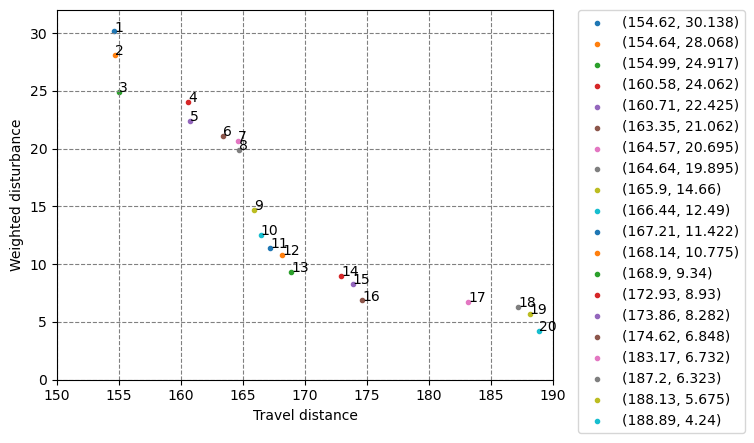

In [52]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

<font color="blue">
  <div align="center">There are exactly</div>
</font>

<div align="center">6 supported solutions.</div>
<div align="justify">These are 1, 2, 3, 13, 16, 20</div>

It is important to note that the old solution 13 was removed, but index 13 was reassigned to the next solution.  
To avoid confusion, the solution `(168.91, 9.707)` is not efficient and has not been included.  
The solution that moved from index 14 to index 13 is `(168.9, 9.34)`, and it is a supported solution.


Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.9, 1.1]$.

In [53]:
for cs in CHARGESUP.values():
    cs.RHS = 1.1
    
for ci in CHARGEINF.values():
    ci.RHS = 0.9

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\942549307.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,162.43,28.352,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,162.43,28.352,2,22,"[11, 13, 14, 17]",1.073,9.19
2,0,162.43,28.352,3,22,"[10, 15, 16, 18]",1.087,7.02
3,0,162.43,28.352,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
5,1,162.81,24.862,2,22,"[10, 14]",1.071,4.51
6,1,162.81,24.862,3,22,"[11, 13, 15, 16, 17, 18]",1.089,12.08
7,1,162.81,24.862,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,171.36,24.747,1,22,"[4, 5, 6, 7, 8, 9, 12, 20]",0.933,53.24
9,2,171.36,24.747,2,22,"[10, 14]",1.071,4.51


In [54]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(162.43, 28.352),
 (162.81, 24.862),
 (171.36, 24.747),
 (171.62, 12.168),
 (172.39, 11.1),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.66, 8.492),
 (187.18, 8.393),
 (187.2, 6.323)]

Represent these solutions in bi-criteria space.

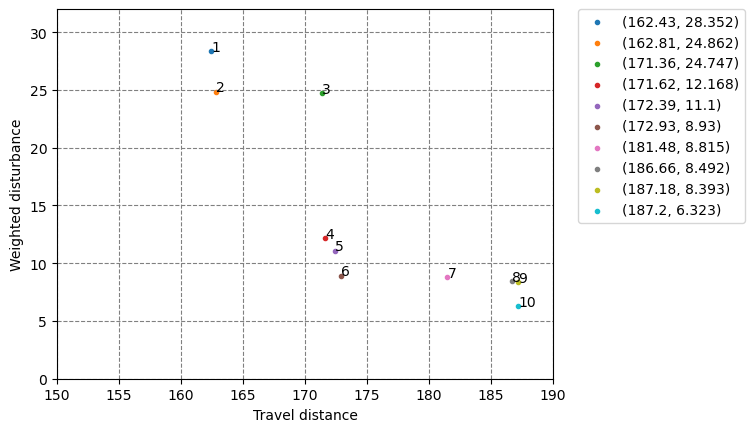

In [55]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.85, 1.15]$.

In [56]:
for cs in CHARGESUP.values():
    cs.RHS = 1.15
    
for ci in CHARGEINF.values():
    ci.RHS = 0.85

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\3950715657.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,160.34,27.645,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,160.34,27.645,2,22,"[11, 13, 14, 18]",1.045,7.56
2,0,160.34,27.645,3,22,"[10, 15, 16, 17]",1.115,6.56
3,0,160.34,27.645,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,160.36,25.575,1,22,"[4, 5, 6, 7, 8, 9, 19]",0.855,24.89
5,1,160.36,25.575,2,22,"[11, 12, 13, 14, 18]",1.127,29.57
6,1,160.36,25.575,3,22,"[10, 15, 16, 17]",1.115,6.56
7,1,160.36,25.575,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
9,2,162.81,24.862,2,22,"[10, 14]",1.071,4.51


In [57]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(160.34, 27.645),
 (160.36, 25.575),
 (162.81, 24.862),
 (169.11, 24.508),
 (171.6, 14.238),
 (171.62, 12.168),
 (172.14, 12.068),
 (172.16, 9.998),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.43, 7.39),
 (187.2, 6.323)]

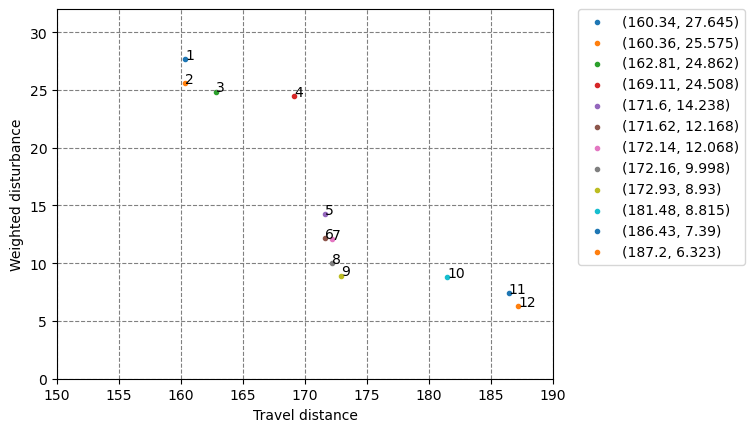

In [58]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

## Scaling up the model
With 10 SRs and 100 zones 

- Visual representation of the solution in the decision space




Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-06
Single-objective (min travel distance): z1 = 1520.35, z2 = 0.00%
Single-objective (min disturbance): z1 = 1520.35, z2 = 0.00%
Iteration 0: z1 = 1520.35, z2 = 0.00

Pareto frontier (z1, z2):
(1520.3480089088243, 0.0)


C:\Users\Edison Araki\AppData\Local\Temp\ipykernel_15540\951916790.py:215: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_srs)


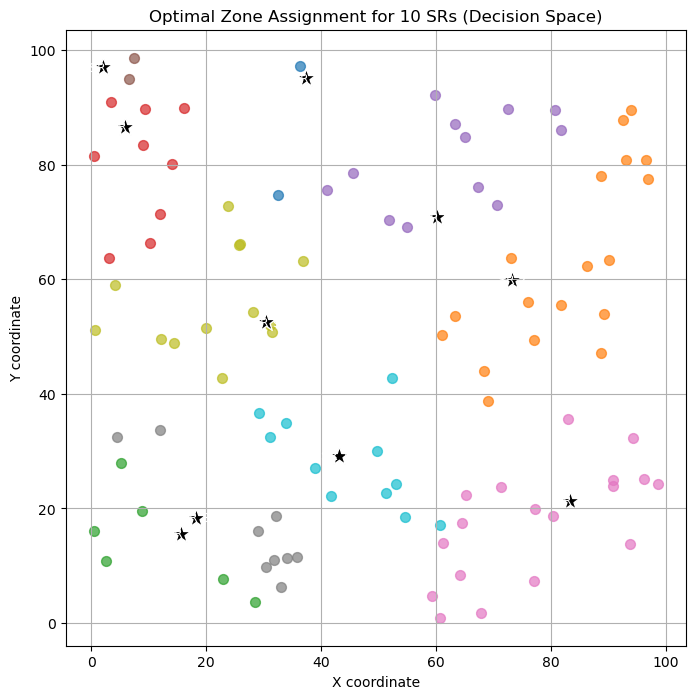

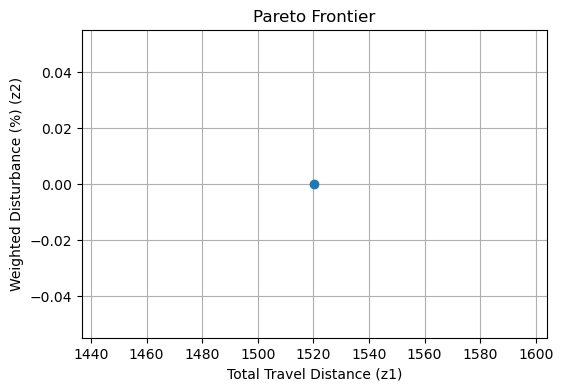

In [1]:
"""
Scaling the assignment model to 10 SRs and 100 zones,
and visualizing the solution in the decision space.
"""

import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# Set a random seed for reproducibility
np.random.seed(42)

# -------------------------------
# 1. DATA GENERATION
# -------------------------------

num_srs   = 10
num_zones = 100

# Generate random coordinates for SR offices (in a 100x100 area)
sr_coords = { i: (np.random.uniform(0,100), np.random.uniform(0,100)) 
              for i in range(1, num_srs+1) }

# Generate random coordinates for zones
zone_coords = { j: (np.random.uniform(0,100), np.random.uniform(0,100))
                for j in range(1, num_zones+1) }

# Generate random raw workloads for zones and then normalize so that total workload = num_srs (i.e. 10)
raw_workloads = np.random.uniform(0.5, 1.5, size=num_zones)
total_raw     = np.sum(raw_workloads)
zone_workloads = { j: (raw_workloads[j-1] / total_raw) * num_srs 
                   for j in range(1, num_zones+1) }
# With this normalization, if zones were evenly distributed then each SR would get about 1 unit of workload.

# -------------------------------
# 2. DISTANCE COMPUTATION
# -------------------------------

# Compute Euclidean distance from each SR office to each zone
distance = {}
for i in range(1, num_srs+1):
    for j in range(1, num_zones+1):
        x_i, y_i = sr_coords[i]
        x_j, y_j = zone_coords[j]
        distance[(i,j)] = np.hypot(x_i - x_j, y_i - y_j)

# -------------------------------
# 3. CURRENT ASSIGNMENT
# -------------------------------
# For a baseline assignment, assign each zone to the SR whose office is nearest.

current_assignment = {}
for j in range(1, num_zones+1):
    best_i   = None
    best_d   = float('inf')
    for i in range(1, num_srs+1):
        d_ij = distance[(i,j)]
        if d_ij < best_d:
            best_d = d_ij
            best_i = i
    # Mark the chosen assignment: for each (i,j) pair, store 1 if zone j was originally assigned to SR i.
    for i in range(1, num_srs+1):
        current_assignment[(i,j)] = 1 if i == best_i else 0

# Compute the current workload for each SR
current_workload = { i: sum(zone_workloads[j] 
                              for j in range(1, num_zones+1)
                              if current_assignment[(i,j)]==1)
                     for i in range(1, num_srs+1) }

# -------------------------------
# 4. BUILDING THE OPTIMIZATION MODEL
# -------------------------------

model = Model("Assignment_10SR_100Zones")
model.Params.OutputFlag = 0  # Turn off solver output

# Decision Variables: X[i,j] = 1 if zone j is assigned to SR i, 0 otherwise.
X = {}
for i in range(1, num_srs+1):
    for j in range(1, num_zones+1):
        X[(i,j)] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
model.update()

# (a) Each zone must be assigned to exactly one SR.
for j in range(1, num_zones+1):
    model.addConstr(quicksum(X[(i,j)] for i in range(1, num_srs+1)) == 1,
                    name=f"AssignZone_{j}")

# (b) Workload constraints for each SR.
# We allow a ±20% variation relative to the current workload.
for i in range(1, num_srs+1):
    workload_expr = quicksum(zone_workloads[j] * X[(i,j)] for j in range(1, num_zones+1))
    lb = 0.8 * current_workload[i]
    ub = 1.2 * current_workload[i]
    model.addConstr(workload_expr >= lb, name=f"WorkloadLB_{i}")
    model.addConstr(workload_expr <= ub, name=f"WorkloadUB_{i}")

model.update()

# -------------------------------
# 5. OBJECTIVE FUNCTIONS
# -------------------------------

# Objective z1: Total travel distance
z1 = quicksum(distance[(i,j)] * X[(i,j)] for i in range(1, num_srs+1)
                                         for j in range(1, num_zones+1))

# Objective z2: Weighted disturbance relative to the current assignment.
# It penalizes reassignments relative to the baseline.
total_workload = sum(zone_workloads.values())  # should equal num_srs (i.e. 10)
z2 = 100 * quicksum(zone_workloads[j] * (1 - current_assignment[(i,j)]) * X[(i,j)]
                    for i in range(1, num_srs+1)
                    for j in range(1, num_zones+1)) / total_workload

# A small helper function to compute z2 from a solution dictionary.
def compute_z2(sol):
    return 100 * sum(zone_workloads[j] * (1 - current_assignment[(i,j)]) * sol[(i,j)]
                     for i in range(1, num_srs+1)
                     for j in range(1, num_zones+1)) / total_workload

# -------------------------------
# 6. SOLVE SINGLE-OBJECTIVE VERSIONS
# -------------------------------

# (i) Optimize for travel distance only.
model.setObjective(z1, GRB.MINIMIZE)
model.update()
model.optimize()

sol_values = {(i,j): X[(i,j)].x for i in range(1, num_srs+1) for j in range(1, num_zones+1)}
opt_z1 = model.objVal
opt_z2 = compute_z2(sol_values)
print(f"Single-objective (min travel distance): z1 = {opt_z1:.2f}, z2 = {opt_z2:.2f}%")

# (ii) Optimize for weighted disturbance only.
model.setObjective(z2, GRB.MINIMIZE)
model.update()
model.optimize()

sol_values = {(i,j): X[(i,j)].x for i in range(1, num_srs+1) for j in range(1, num_zones+1)}
opt_z2_single = compute_z2(sol_values)
# Compute travel distance from the obtained solution:
opt_z1_single = sum(distance[(i,j)] * sol_values[(i,j)]
                    for i in range(1, num_srs+1)
                    for j in range(1, num_zones+1))
print(f"Single-objective (min disturbance): z1 = {opt_z1_single:.2f}, z2 = {opt_z2_single:.2f}%")

# -------------------------------
# 7. EPSILON-CONSTRAINT: GENERATE THE PARETO FRONTIER
# -------------------------------

# We now set the objective to minimize z1 while adding a constraint on z2.
# Start with the z1–optimal solution and then iteratively require z2 <= current_z2 - epsilon.
epsilon = 0.001
pareto_solutions = []   # list of tuples (z1, z2)
eps_constraints = []    # list to store the added constraints

# Reset objective to z1 minimization.
model.setObjective(z1, GRB.MINIMIZE)
model.update()

iteration = 0
while True:
    model.optimize()
    if model.status != GRB.OPTIMAL:
        break
    sol_values = {(i,j): X[(i,j)].x for i in range(1, num_srs+1) for j in range(1, num_zones+1)}
    current_z1 = sum(distance[(i,j)] * sol_values[(i,j)]
                     for i in range(1, num_srs+1)
                     for j in range(1, num_zones+1))
    current_z2 = compute_z2(sol_values)
    pareto_solutions.append((current_z1, current_z2))
    print(f"Iteration {iteration}: z1 = {current_z1:.2f}, z2 = {current_z2:.2f}")
    
    # Add an epsilon constraint to force a lower z2 in the next iteration.
    eps_constr = model.addConstr(z2 <= current_z2 - epsilon, name=f"eps_{iteration}")
    eps_constraints.append(eps_constr)
    model.update()
    iteration += 1
    
    # Check feasibility: if the new constraint makes the problem infeasible, exit.
    model.optimize()
    if model.status != GRB.OPTIMAL:
        break

print("\nPareto frontier (z1, z2):")
for sol in pareto_solutions:
    print(sol)

# -------------------------------
# 8. VISUAL REPRESENTATION: DECISION SPACE
# -------------------------------
# We now extract a (typically z1–optimal) solution and plot the zones colored by their assigned SR.
# In a real-world application the “decision space” is the actual geographical layout.
#
# (a) Re-solve for z1 minimization (if needed) and extract the assignment.
model.setObjective(z1, GRB.MINIMIZE)
# (Optional) Remove epsilon constraints before re-solving.
for c in eps_constraints:
    model.remove(c)
model.update()
model.optimize()

sol_values = {(i,j): X[(i,j)].x for i in range(1, num_srs+1) for j in range(1, num_zones+1)}
# Determine for each zone the assigned SR (each zone should have exactly one SR with x ~ 1).
zone_assignment = {}
for j in range(1, num_zones+1):
    for i in range(1, num_srs+1):
        if sol_values[(i,j)] > 0.5:
            zone_assignment[j] = i
            break

# Create a plot of the zones (colored by assigned SR) and mark SR office locations.
colors = plt.cm.get_cmap("tab10", num_srs)
plt.figure(figsize=(8,8))
for j in range(1, num_zones+1):
    assigned_sr = zone_assignment[j]
    x, y = zone_coords[j]
    plt.scatter(x, y, color=colors(assigned_sr-1), s=50, alpha=0.7)
    
# Mark SR offices with a star marker and label them.
for i in range(1, num_srs+1):
    x, y = sr_coords[i]
    plt.scatter(x, y, color="black", marker="*", s=200, edgecolors="white")
    plt.text(x, y, f"SR {i}", color="white", fontsize=9, ha="center", va="center")
    
plt.title("Optimal Zone Assignment for 10 SRs (Decision Space)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.show()

# -------------------------------
# (b) Additionally, plot the Pareto frontier in objective space.
pareto_solutions = np.array(pareto_solutions)
if pareto_solutions.size > 0:
    plt.figure(figsize=(6,4))
    plt.plot(pareto_solutions[:,0], pareto_solutions[:,1], marker='o')
    plt.xlabel("Total Travel Distance (z1)")
    plt.ylabel("Weighted Disturbance (%) (z2)")
    plt.title("Pareto Frontier")
    plt.grid(True)
    plt.show()


# Step 2

## **Exercise**: 
Is your first model able to solve the 100 bricks / 10 SRs instances? compute and represent the corresponding sets of non-dominated solutions.

### Data Generation


### Model Formulation

1. **Variables**:  
   $$
   X_{ij} = 
   \begin{cases}
   1 & \text{if brick } j \text{ is assigned to SR } i,\\
   0 & \text{otherwise}.
   \end{cases}
   $$

2. **Constraints**:
   - **Unique Assignment**:  
     $$
       \sum_{i=1}^{\text{SRs}} X_{ij} = 1 \quad \forall j.
     $$
   - **Workload Bounds**:  
     $$
       \text{lower} \;\le\; \sum_{j=1}^{\text{Bricks}} w_j \,X_{ij} \;\le\; \text{upper}
       \quad \forall i.
     $$

Binary assignment solution:
  Total travel distance: 1718.81

Partial (fractional) assignment solution:
  Total travel distance: 1697.15


C:\Users\Edison Araki\AppData\Local\Temp\ipykernel_15540\3922756509.py:157: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_srs)


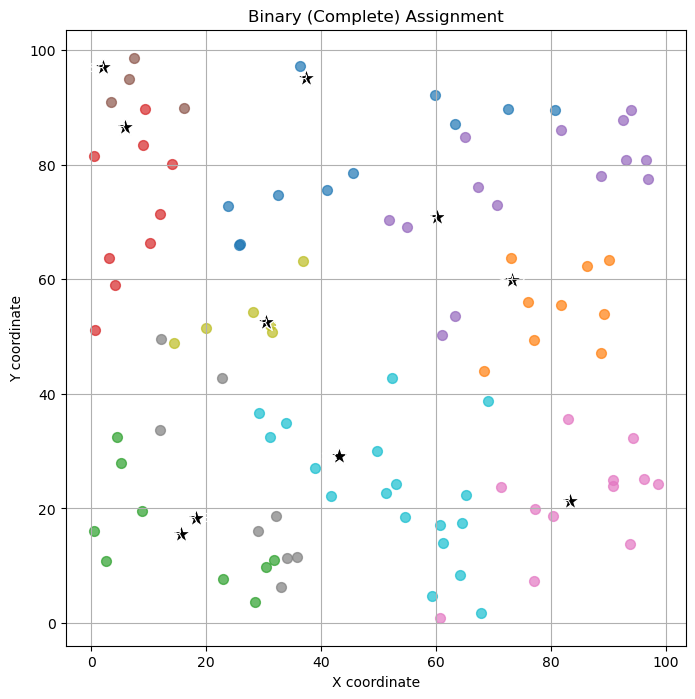

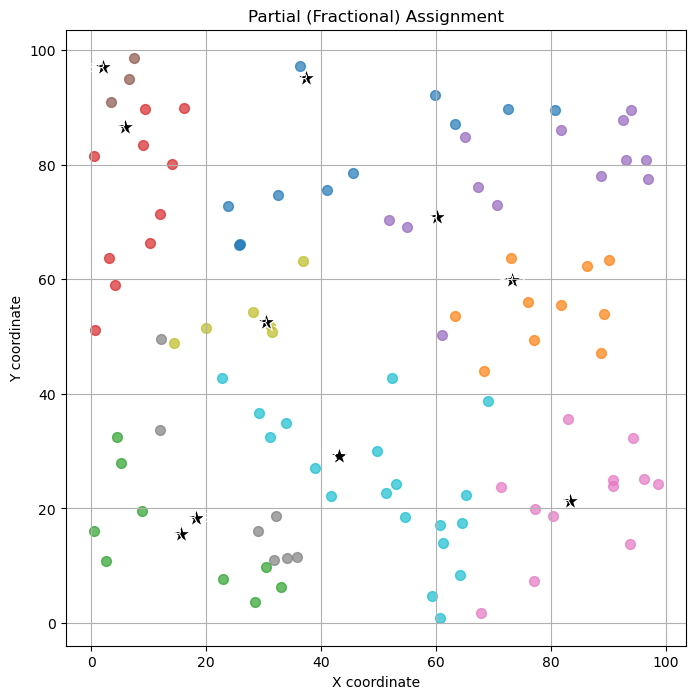


Comparison:
  Binary assignment travel distance:  1718.81
  Partial assignment travel distance: 1697.15


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Comparison of Binary vs. Partial (Fractional) Brick Assignment
for a 10 SR / 100 zone instance.
"""

import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# -------------------------------
# 1. DATA GENERATION
# -------------------------------

np.random.seed(42)

num_srs   = 10
num_zones = 100

# Generate random coordinates for SR offices (in a 100x100 area)
sr_coords = { i: (np.random.uniform(0,100), np.random.uniform(0,100)) 
              for i in range(1, num_srs+1) }

# Generate random coordinates for zones (bricks)
zone_coords = { j: (np.random.uniform(0,100), np.random.uniform(0,100))
                for j in range(1, num_zones+1) }

# Generate random raw workloads for zones and normalize so that total workload = num_srs (i.e. 10)
raw_workloads = np.random.uniform(0.5, 1.5, size=num_zones)
total_raw     = np.sum(raw_workloads)
zone_workloads = { j: (raw_workloads[j-1] / total_raw) * num_srs 
                   for j in range(1, num_zones+1) }

# -------------------------------
# 2. DISTANCE COMPUTATION
# -------------------------------

# Euclidean distance from each SR office to each zone
distance = {}
for i in range(1, num_srs+1):
    for j in range(1, num_zones+1):
        x_i, y_i = sr_coords[i]
        x_j, y_j = zone_coords[j]
        distance[(i,j)] = np.hypot(x_i - x_j, y_i - y_j)

# -------------------------------
# 3. BASELINE ASSIGNMENT
# -------------------------------
# For demonstration, we create a random baseline assignment.
# (In previous examples we might use the "nearest SR" assignment.)
current_assignment = {}
for j in range(1, num_zones+1):
    random_sr = np.random.randint(1, num_srs+1)
    for i in range(1, num_srs+1):
         current_assignment[(i,j)] = 1 if i == random_sr else 0

# Compute the current workload for each SR based on the baseline.
current_workload = { i: sum(zone_workloads[j] 
                              for j in range(1, num_zones+1)
                              if current_assignment[(i,j)]==1)
                     for i in range(1, num_srs+1) }

# -------------------------------
# 4. MODEL SOLUTION FUNCTION
# -------------------------------

def solve_assignment_model(var_type):
    """
    Builds and solves the assignment model.
    
    Parameters:
      var_type: either GRB.BINARY (for complete assignment) or GRB.CONTINUOUS (for partial assignment).
                In the continuous case we restrict 0 <= x_{ij} <= 1.
                
    Returns:
      sol: dictionary of variable values x[(i,j)]
      obj: optimal travel distance objective value.
      model: the solved Gurobi model (in case you want to inspect further).
    """
    model = Model("AssignmentModel")
    model.Params.OutputFlag = 0  # suppress solver output
    
    # Decision Variables: x[i,j] in [0,1]. For a binary model, var_type is GRB.BINARY.
    X = {}
    for i in range(1, num_srs+1):
        for j in range(1, num_zones+1):
            # For continuous (partial assignment), we force 0 <= x_{ij} <= 1.
            X[(i,j)] = model.addVar(vtype=var_type, lb=0, ub=1, name=f"x_{i}_{j}")
    model.update()

    # Constraint 1: Each zone (brick) must be completely assigned:
    #   sum_{i=1}^{num_srs} x_{ij} = 1  for every zone j.
    for j in range(1, num_zones+1):
        model.addConstr(quicksum(X[(i,j)] for i in range(1, num_srs+1)) == 1,
                        name=f"AssignZone_{j}")

    # Constraint 2: Workload constraints for each SR.
    # We allow a ±20% variation relative to the baseline workload.
    for i in range(1, num_srs+1):
        workload_expr = quicksum(zone_workloads[j] * X[(i,j)] for j in range(1, num_zones+1))
        lb = 0.8 * current_workload[i]
        ub = 1.2 * current_workload[i]
        model.addConstr(workload_expr >= lb, name=f"WorkloadLB_{i}")
        model.addConstr(workload_expr <= ub, name=f"WorkloadUB_{i}")

    model.update()

    # Objective: Minimize total travel distance
    z1 = quicksum(distance[(i,j)] * X[(i,j)] for i in range(1, num_srs+1)
                                          for j in range(1, num_zones+1))
    model.setObjective(z1, GRB.MINIMIZE)
    model.update()
    model.optimize()
    
    sol = {(i,j): X[(i,j)].x for i in range(1, num_srs+1) for j in range(1, num_zones+1)}
    return sol, model.objVal, model

# -------------------------------
# 5. SOLVE THE MODEL FOR THE TWO CASES
# -------------------------------

# (A) Binary (complete) assignment:
binary_sol, binary_obj, binary_model = solve_assignment_model(GRB.BINARY)
print("Binary assignment solution:")
print(f"  Total travel distance: {binary_obj:.2f}")

# (B) Partial (fractional) assignment:
partial_sol, partial_obj, partial_model = solve_assignment_model(GRB.CONTINUOUS)
print("\nPartial (fractional) assignment solution:")
print(f"  Total travel distance: {partial_obj:.2f}")

# -------------------------------
# 6. VISUALIZATION OF THE DECISION SPACE
# -------------------------------
# For visualization we will plot the zones (bricks) colored by the SR to which most of the brick is assigned.
# For the binary solution, the assignment is clear.
# For the partial solution, we assign each brick to the SR with the highest fraction.

def extract_zone_assignment(sol):
    """Return a dictionary: zone j -> assigned SR (the one with highest fraction)."""
    assignment = {}
    for j in range(1, num_zones+1):
        best_i = None
        best_val = -1
        for i in range(1, num_srs+1):
            if sol[(i,j)] > best_val:
                best_val = sol[(i,j)]
                best_i = i
        assignment[j] = best_i
    return assignment

binary_assignment = extract_zone_assignment(binary_sol)
partial_assignment = extract_zone_assignment(partial_sol)

def plot_decision_space(assignment, title):
    colors = plt.cm.get_cmap("tab10", num_srs)
    plt.figure(figsize=(8,8))
    for j in range(1, num_zones+1):
        assigned_sr = assignment[j]
        x, y = zone_coords[j]
        plt.scatter(x, y, color=colors(assigned_sr-1), s=50, alpha=0.7)
    # Mark SR offices with a star and label them.
    for i in range(1, num_srs+1):
        x, y = sr_coords[i]
        plt.scatter(x, y, color="black", marker="*", s=200, edgecolors="white")
        plt.text(x, y, f"SR {i}", color="white", fontsize=9, ha="center", va="center")
    plt.title(title)
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)
    plt.show()

plot_decision_space(binary_assignment, "Binary (Complete) Assignment")
plot_decision_space(partial_assignment, "Partial (Fractional) Assignment")

# -------------------------------
# 7. COMPARISON OF RESULTS
# -------------------------------
print("\nComparison:")
print(f"  Binary assignment travel distance:  {binary_obj:.2f}")
print(f"  Partial assignment travel distance: {partial_obj:.2f}")

# In many cases the relaxation (partial assignment) may allow more flexibility.
# For example, the model might be able to reduce the total travel distance further
# by “splitting” a brick between two SRs to better balance travel cost versus workload.


## Increase the demand + 25% with a new SR

-------------------------------------------------------
Assignment with 4 SR's (increased demand):
  Total travel distance: 765.37
-------------------------------------------------------

-------------------------------------------------------
Assignment with 5 SR's (increased demand, new SR hired):
  Total travel distance: 575.34
  New SR's office (center brick): 8
-------------------------------------------------------



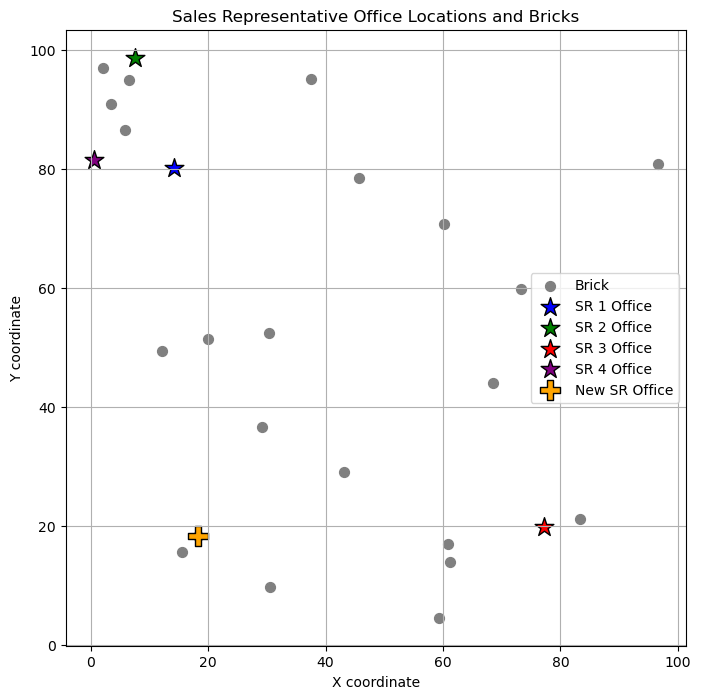

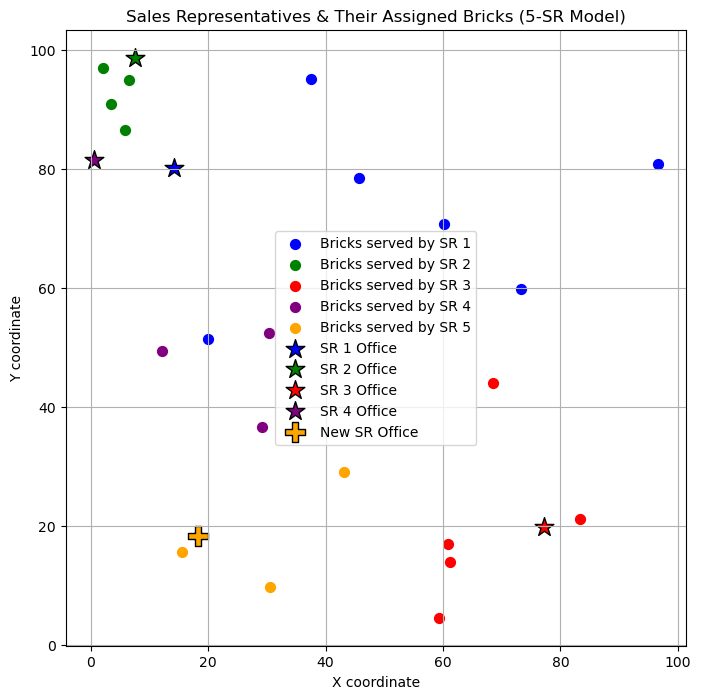

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Modeling the addition of a new Sales Representative when demand increases uniformly by 25%.
In this model, the workloads for all bricks are multiplied by 1.25.
Because the original 4 SR’s would then exceed their capacity,
a new SR is hired and his/her office location (center brick) is decided by the model.
"""

import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

# -------------------------------
# 1. DATA GENERATION
# -------------------------------

np.random.seed(42)

num_bricks = 22
num_sr_existing = 4  # original sales representatives

# Generate synthetic brick coordinates (for visualization and distance computation)
brick_coords = { j: (np.random.uniform(0,100), np.random.uniform(0,100)) 
                 for j in range(1, num_bricks+1) }

# Generate synthetic workloads for bricks (original values)
raw_workloads = np.random.uniform(0.5, 1.5, num_bricks)
brick_workloads = { j: raw_workloads[j-1] for j in range(1, num_bricks+1) }

# Increase all brick workloads uniformly by 25%
brick_workloads_inc = { j: 1.25 * brick_workloads[j] for j in range(1, num_bricks+1) }

# For the existing sales reps, assume their office locations are fixed.
# We generate random coordinates for the 4 existing SR offices.
sr_existing_coords = { i: (np.random.uniform(0,100), np.random.uniform(0,100))
                       for i in range(1, num_sr_existing+1) }

# Euclidean distance function
def euclidean(a, b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

# Precompute distances from each existing SR office to every brick.
distance_existing = {(i, j): euclidean(sr_existing_coords[i], brick_coords[j])
                     for i in range(1, num_sr_existing+1)
                     for j in range(1, num_bricks+1)}

# -------------------------------
# 2. MODEL WITH 4 SALES REPRESENTATIVES (Increased Demand)
# -------------------------------
# We first attempt to assign all bricks (with increased workload) to the 4 existing SR’s.
model_4 = Model("Assignment4SR")
model_4.Params.OutputFlag = 0  # suppress solver output

# Decision variables: x[i,j] = 1 if brick j is assigned to SR i (i=1..4)
x_4 = {}
for i in range(1, num_sr_existing+1):
    for j in range(1, num_bricks+1):
        x_4[(i,j)] = model_4.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
model_4.update()

# Each brick must be assigned to exactly one SR.
for j in range(1, num_bricks+1):
    model_4.addConstr(quicksum(x_4[(i,j)] for i in range(1, num_sr_existing+1)) == 1,
                      name=f"AssignBrick_{j}")

# Workload constraints: 
# Let total increased workload be T and the average load (if perfectly balanced) be T/4.
total_workload_inc = sum(brick_workloads_inc[j] for j in range(1, num_bricks+1))
avg_workload_4 = total_workload_inc / num_sr_existing
# For each SR, we require its load to be within ±20% of the average.
for i in range(1, num_sr_existing+1):
    workload_expr = quicksum(brick_workloads_inc[j] * x_4[(i,j)] for j in range(1, num_bricks+1))
    model_4.addConstr(workload_expr >= 0.8 * avg_workload_4, name=f"WL_LB_{i}")
    model_4.addConstr(workload_expr <= 1.2 * avg_workload_4, name=f"WL_UB_{i}")
model_4.update()

# Objective: minimize total travel distance for existing SR's.
model_4.setObjective(quicksum(distance_existing[(i,j)] * x_4[(i,j)]
                              for i in range(1, num_sr_existing+1)
                              for j in range(1, num_bricks+1)),
                      GRB.MINIMIZE)
model_4.optimize()

print("-------------------------------------------------------")
print("Assignment with 4 SR's (increased demand):")
if model_4.status == GRB.OPTIMAL:
    print("  Total travel distance: {:.2f}".format(model_4.objVal))
else:
    print("  Model with 4 SR's is infeasible or suboptimal.")
print("-------------------------------------------------------\n")

# -------------------------------
# 3. MODEL WITH 5 SALES REPRESENTATIVES (Adding a New SR)
# -------------------------------
# Now we add a new SR (so total SR's = 5) to help serve the increased demand.
# For the new SR (indexed as 5), his/her office location is not fixed.
# We introduce binary variables y[j] for j=1,...,num_bricks to decide which brick will serve as the center (office location)
# for the new SR. (Exactly one y[j] will be 1.)
num_sr_total = num_sr_existing + 1  # now 5 SR's

model_5 = Model("Assignment5SR")
model_5.Params.OutputFlag = 0

# Decision variables: for i = 1,...,5 and each brick j, x[(i,j)] = 1 if brick j is assigned to SR i.
x = {}
for i in range(1, num_sr_total+1):
    for j in range(1, num_bricks+1):
        x[(i,j)] = model_5.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

# For the new SR (i = 5), his/her office location is to be decided.
# Introduce variables y[j] (for j = 1,...,num_bricks) where y[j] = 1 if brick j is chosen as the new center.
y = {}
for j in range(1, num_bricks+1):
    y[j] = model_5.addVar(vtype=GRB.BINARY, name=f"y_{j}")
model_5.update()

# Assignment constraints: every brick j must be assigned to exactly one SR (among the 5).
for j in range(1, num_bricks+1):
    model_5.addConstr(quicksum(x[(i,j)] for i in range(1, num_sr_total+1)) == 1,
                      name=f"AssignBrick_{j}")

# Workload constraints:
# With increased demand the total workload is unchanged (total_workload_inc) but now divided among 5 SR's.
avg_workload_5 = total_workload_inc / num_sr_total
for i in range(1, num_sr_total+1):
    workload_expr = quicksum(brick_workloads_inc[j] * x[(i,j)] for j in range(1, num_bricks+1))
    model_5.addConstr(workload_expr >= 0.8 * avg_workload_5, name=f"WL_LB_{i}")
    model_5.addConstr(workload_expr <= 1.2 * avg_workload_5, name=f"WL_UB_{i}")

# For the new SR, we must choose one center brick.
model_5.addConstr(quicksum(y[j] for j in range(1, num_bricks+1)) == 1, name="ChooseCenter")
model_5.update()

# Now, define the travel cost.
# For the existing SR's (i = 1,...,4), the cost for brick j is given by the fixed distance from their office.
# For the new SR (i = 5), the cost for serving brick j depends on the chosen center.
# First, precompute distances between bricks (this will serve as the distance between the new SR's center and any brick).
d_brick = {}
for k in range(1, num_bricks+1):
    for j in range(1, num_bricks+1):
        d_brick[(k,j)] = euclidean(brick_coords[k], brick_coords[j])

# For the new SR, if the center is at brick k (y[k] = 1), then the cost to serve brick j is d_brick[(k,j)].
# We model that as: cost_new(j) = sum_{k} y[k] * d_brick[(k,j)].
obj_new = quicksum( (quicksum(y[k]*d_brick[(k,j)] for k in range(1, num_bricks+1)))* x[(num_sr_total, j)]
                    for j in range(1, num_bricks+1))

# For the existing SR's, the cost is as before.
obj_existing = quicksum(distance_existing[(i,j)] * x[(i,j)]
                        for i in range(1, num_sr_existing+1)
                        for j in range(1, num_bricks+1))

# Total objective: minimize total travel distance.
model_5.setObjective(obj_existing + obj_new, GRB.MINIMIZE)
model_5.update()
model_5.optimize()

print("-------------------------------------------------------")
print("Assignment with 5 SR's (increased demand, new SR hired):")
if model_5.status == GRB.OPTIMAL:
    print("  Total travel distance: {:.2f}".format(model_5.objVal))
    # Determine which brick was chosen as the center for the new SR.
    new_center = [j for j in range(1, num_bricks+1) if y[j].x > 0.5]
    if new_center:
        print("  New SR's office (center brick):", new_center[0])
    else:
        print("  No center brick was selected (unexpected).")
else:
    print("  Model with 5 SR's is infeasible or suboptimal.")
print("-------------------------------------------------------\n")

# -------------------------------
# 4. (Optional) VISUALIZATION
# -------------------------------
# For visualization we can plot the brick locations and the positions of the existing SR offices.
# We also mark the chosen center brick for the new SR.

colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(8,8))
# Plot bricks
for j in range(1, num_bricks+1):
    plt.scatter(brick_coords[j][0], brick_coords[j][1], color='gray', s=50, label="Brick" if j==1 else "")
# Plot existing SR offices
for i in range(1, num_sr_existing+1):
    plt.scatter(sr_existing_coords[i][0], sr_existing_coords[i][1], color=colors[i-1],
                marker="*", s=200, edgecolors="black", label=f"SR {i} Office")
# Mark the new SR's chosen center brick (if available)
if model_5.status == GRB.OPTIMAL and new_center:
    center = new_center[0]
    plt.scatter(brick_coords[center][0], brick_coords[center][1], color=colors[-1],
                marker="P", s=200, edgecolors="black", label="New SR Office")
    
plt.title("Sales Representative Office Locations and Bricks")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.grid(True)
plt.show()# -------------------------------
# 4. (Optional) VISUALIZATION
# -------------------------------
import matplotlib.pyplot as plt

colors = ['blue', 'green', 'red', 'purple', 'orange']  # one color per SR (up to 5)

# First, figure out the SR assignment for each brick in the 5-SR model.
# x[(i,j)] = 1 if brick j is assigned to SR i. We'll store assigned_sr[j] = i.
assigned_sr = {}
if model_5.status == GRB.OPTIMAL:
    for j in range(1, num_bricks+1):
        for i in range(1, num_sr_total+1):
            if x[(i,j)].x > 0.5:
                assigned_sr[j] = i
                break

plt.figure(figsize=(8,8))

# --- Plot bricks grouped by assigned SR ---
# We do one scatter plot per SR so the legend is grouped by SR color.
for i in range(1, num_sr_total+1):
    x_vals = []
    y_vals = []
    for j in range(1, num_bricks+1):
        if assigned_sr.get(j) == i:
            x_vals.append(brick_coords[j][0])
            y_vals.append(brick_coords[j][1])
    # Plot all bricks assigned to SR i in the same color
    plt.scatter(x_vals, y_vals, color=colors[i-1], s=50, 
                label=f"Bricks served by SR {i}")

# --- Plot existing SR offices with the same colors (markers = star) ---
for i in range(1, num_sr_existing+1):
    plt.scatter(sr_existing_coords[i][0], sr_existing_coords[i][1], 
                color=colors[i-1], marker="*", s=200, 
                edgecolors="black", label=f"SR {i} Office")

# --- Plot new SR’s chosen center with the same color (marker = 'P') ---
if model_5.status == GRB.OPTIMAL and new_center:
    center = new_center[0]  # the brick that was chosen as the center
    # The new SR is the 5th in our indexing
    plt.scatter(brick_coords[center][0], brick_coords[center][1], 
                color=colors[num_sr_total-1], marker="P", s=200, 
                edgecolors="black", label="New SR Office")

plt.title("Sales Representatives & Their Assigned Bricks (5-SR Model)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.grid(True)
plt.show()



## Step 3

Generalizing the model to handles dinamic location of the "center bricks"


• Formulate a bi-objective optimization problem in which positions of offices are variables and in which the two objectives are the total distance (min), and the workload of SRs (MinMax).

C:\Users\Edison Araki\AppData\Local\Temp\ipykernel_15540\4151030928.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_sr)


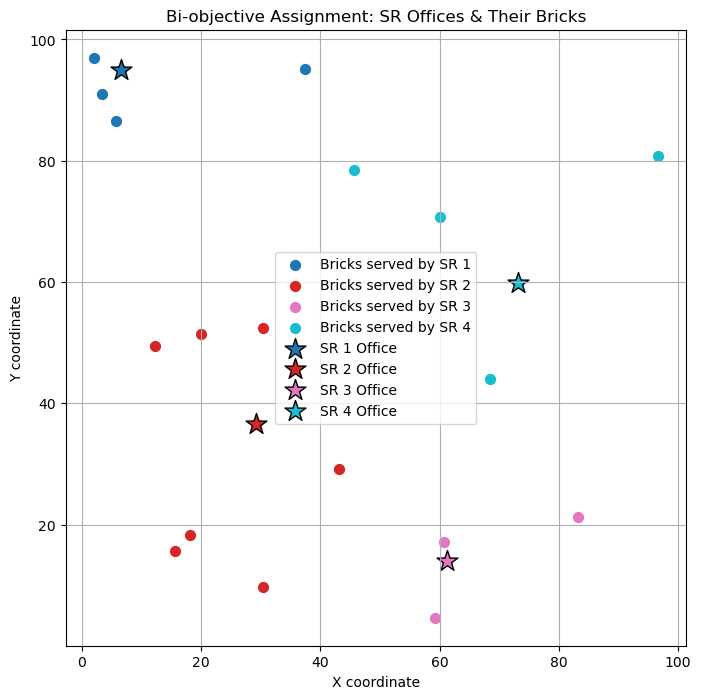

In [6]:
# -------------------------------
# 6. (Optional) VISUALIZATION
# -------------------------------
import matplotlib.pyplot as plt

# 1) Determine the SR assignment for each brick.
#    For each brick j, we find the i such that x[i,j] == 1.
assigned_sr = {}
for j in J:
    for i in I:
        if x[(i,j)].x > 0.5:
            assigned_sr[j] = i
            break

# 2) Create a color map (for up to num_sr distinct colors).
colors = plt.cm.get_cmap("tab10", num_sr)

plt.figure(figsize=(8,8))

# 3) Plot the bricks, grouped by SR assignment.
for i in I:
    xs = []
    ys = []
    for j in J:
        if assigned_sr.get(j) == i:
            xs.append(brick_coords[j][0])
            ys.append(brick_coords[j][1])
    # Plot all bricks assigned to SR i with color = colors(i-1)
    plt.scatter(xs, ys, color=colors(i-1), s=50, label=f"Bricks served by SR {i}")

# 4) Plot each SR office in the same color (marker = '*').
for i in I:
    center = [k for k in J if y[(i,k)].x > 0.5]
    if center:
        # We'll take the first center if there are multiple (normally just one).
        k = center[0]
        plt.scatter(brick_coords[k][0], brick_coords[k][1],
                    color=colors(i-1), marker="*", s=250,
                    edgecolors="black", label=f"SR {i} Office")

plt.title("Bi-objective Assignment: SR Offices & Their Bricks")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.grid(True)
plt.show()


Compute the sets of non-dominated solutions for the three-objective problem (total distance,
workload fairness, and number of relocated offices).

Baseline centers: {1: 9, 2: 15, 3: 13, 4: 1}

Non-dominated solutions (Total Distance, Maximum Workload, Disruption):
  Z1 = 500.98, T = 2.00, D = 0
  Z1 = 402.16, T = 2.00, D = 1
  Z1 = 370.27, T = 2.00, D = 2
  Z1 = 342.53, T = 2.00, D = 3
  Z1 = 327.21, T = 2.00, D = 4


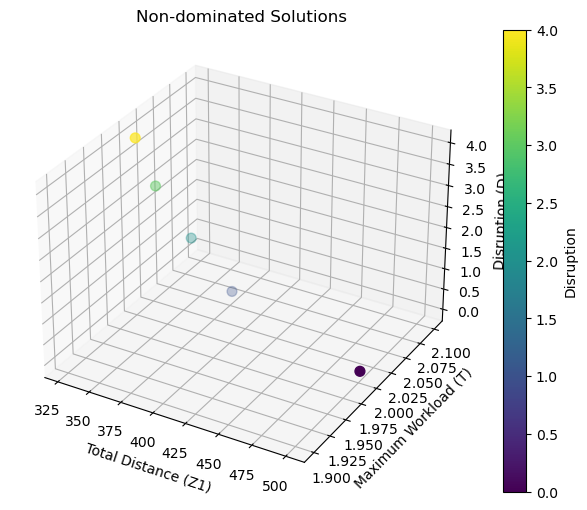

In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Three-objective assignment model with adjustable SR center locations.
Objectives:
  1. Minimize total travel distance (Z1).
  2. Minimize maximum workload (T).
  3. Minimize disruption (number of relocated offices) = D.

We compute a set of non-dominated solutions by:
  - Looping over disruption levels d_target in {0, ..., num_sr}.
  - For each fixed d_target, add constraint (disruption == d_target).
  - Then we use an epsilon–constraint approach on T while minimizing Z1.
"""

import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

# -------------------------------
# 1. DATA
# -------------------------------
np.random.seed(42)

num_bricks = 22
num_sr = 4
I = range(1, num_sr+1)         # SR indices
J = range(1, num_bricks+1)     # Brick indices

# Generate synthetic brick coordinates (for facility locations and distances)
brick_coords = {
    j: (np.random.uniform(0,100), np.random.uniform(0,100))
    for j in J
}

# Generate synthetic workloads for bricks and normalize
raw_workloads = np.random.uniform(0.5, 1.5, num_bricks)
total_raw = np.sum(raw_workloads)
w = {
    j: (raw_workloads[j-1] / total_raw) * num_sr
    for j in J
}

# Precompute distances: for each candidate center (brick k) and brick j, compute d[(k,j)]
d = {}
for k in J:
    for j in J:
        ax, ay = brick_coords[k]
        bx, by = brick_coords[j]
        d[(k,j)] = np.hypot(ax - bx, ay - by)

# Baseline center for each SR (from a "previous" solution, here chosen randomly)
baseline = {}
for i in I:
    baseline[i] = np.random.choice(list(J))
print("Baseline centers:", baseline)


# -------------------------------
# 2. MODEL DEFINITION
# -------------------------------
model = Model("ThreeObj_Assignment")
model.Params.OutputFlag = 0  # turn off solver chatter

# Decision variables:
x = {}  # x[i,j] = 1 if brick j is assigned to SR i
for i in I:
    for j in J:
        x[(i,j)] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

y = {}  # y[i,k] = 1 if SR i chooses brick k as office
for i in I:
    for k in J:
        y[(i,k)] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{k}")

z = {}  # z[i,j,k] = 1 if brick j is assigned to SR i AND SR i's office is k
for i in I:
    for j in J:
        for k in J:
            z[(i,j,k)] = model.addVar(vtype=GRB.BINARY, name=f"z_{i}_{j}_{k}")

T_var = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name="T")  # Maximum workload
model.update()

# -------------------------------
# 3. CONSTRAINTS
# -------------------------------
# (a) Each brick j is assigned to exactly one SR.
for j in J:
    model.addConstr(
        quicksum(x[(i,j)] for i in I) == 1, 
        name=f"AssignBrick_{j}"
    )

# (b) Each SR i chooses exactly one office (center brick k).
for i in I:
    model.addConstr(
        quicksum(y[(i,k)] for k in J) == 1, 
        name=f"ChooseCenter_{i}"
    )

# (c) Linking constraints: z[i,j,k] = 1 if x[i,j] = 1 AND y[i,k] = 1.
for i in I:
    for j in J:
        model.addConstr(
            quicksum(z[(i,j,k)] for k in J) == x[(i,j)],
            name=f"Link_x_{i}_{j}"
        )
        for k in J:
            model.addConstr(z[(i,j,k)] <= y[(i,k)], name=f"Link_y_{i}_{j}_{k}")
            model.addConstr(z[(i,j,k)] <= x[(i,j)], name=f"Link_x2_{i}_{j}_{k}")
            model.addConstr(
                z[(i,j,k)] >= x[(i,j)] + y[(i,k)] - 1, 
                name=f"Link_xy_{i}_{j}_{k}"
            )

# (d) Workload constraints: sum of bricks assigned to SR i cannot exceed T_var.
for i in I:
    model.addConstr(
        quicksum(w[j]*x[(i,j)] for j in J) <= T_var,
        name=f"Workload_{i}"
    )

# (e) Disruption expression: # of SRs whose chosen center != baseline[i].
D_expr = quicksum(
    y[(i,k)] 
    for i in I for k in J
    if k != baseline[i]
)
# We will impose D_expr == d_target in the loop below.


# -------------------------------
# 4. OBJECTIVE FUNCTIONS
# -------------------------------
# Primary objective: total travel distance
Z1 = quicksum(d[(k,j)] * z[(i,j,k)] for i in I for j in J for k in J)
# We will do an epsilon–constraint on T_var, and we will fix D_expr each time.


# -------------------------------
# 5. NON-DOMINATED SOLUTIONS
# -------------------------------
non_dominated = []  # store tuples (Z1_value, T_value, D_value)
epsilon = 1e-3

# Because we'll add and remove constraints inside the loop, we must "update" after each.

for d_target in range(num_sr + 1):
    # 1) Impose disruption == d_target
    #    We create the constraint and add it to the model:
    d_constr = model.addConstr(D_expr == d_target, name=f"Disruption_eq_{d_target}")
    model.update()

    # 2) First optimize with no constraint on T beyond the existing "Workload_i" constraints.
    model.setObjective(Z1, GRB.MINIMIZE)
    model.update()
    model.optimize()
    
    # If infeasible or not optimal, remove constraint and move on
    if model.status != GRB.OPTIMAL:
        model.remove(d_constr)
        model.update()
        continue

    # Record the first solution
    best_Z1 = model.objVal
    best_T  = T_var.X  # the maximum workload in the found solution
    non_dominated.append((best_Z1, best_T, d_target))

    # 3) Now tighten T step by step (epsilon-constraint approach on T).
    #    We'll keep adding T_var <= (current best - epsilon) until it becomes infeasible.
    #    Also break if T doesn't improve by more than epsilon to avoid infinite loops.
    old_T = best_T
    iteration = 0
    
    while True:
        tight_constr = model.addConstr(T_var <= old_T - epsilon, name=f"eps_{d_target}_{iteration}")
        model.update()
        model.optimize()
        
        # If infeasible or not optimal, break out of while-loop
        if model.status != GRB.OPTIMAL:
            # remove the last eps-constraint
            model.remove(tight_constr)
            model.update()
            break
        
        # New solution
        new_Z1 = model.objVal
        new_T  = T_var.X
        
        # If T didn't decrease by at least epsilon, we consider we are done
        if old_T - new_T < epsilon:
            model.remove(tight_constr)
            model.update()
            break
        
        # Otherwise, record solution
        non_dominated.append((new_Z1, new_T, d_target))
        old_T = new_T
        iteration += 1

    # Finally remove the disruption constraint before next d_target iteration
    model.remove(d_constr)
    model.update()

# -------------------------------
# 6. RESULTS
# -------------------------------
print("\nNon-dominated solutions (Total Distance, Maximum Workload, Disruption):")
for (valZ1, valT, valD) in non_dominated:
    print(f"  Z1 = {valZ1:.2f}, T = {valT:.2f}, D = {valD}")

# Optional 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
Z1_vals = [sol[0] for sol in non_dominated]
T_vals  = [sol[1] for sol in non_dominated]
D_vals  = [sol[2] for sol in non_dominated]

sc = ax.scatter(Z1_vals, T_vals, D_vals, c=D_vals, cmap="viridis", s=50)
ax.set_xlabel("Total Distance (Z1)")
ax.set_ylabel("Maximum Workload (T)")
ax.set_zlabel("Disruption (D)")
plt.title("Non-dominated Solutions")
plt.colorbar(sc, label="Disruption")
plt.show()


## Step 4 (UTA)

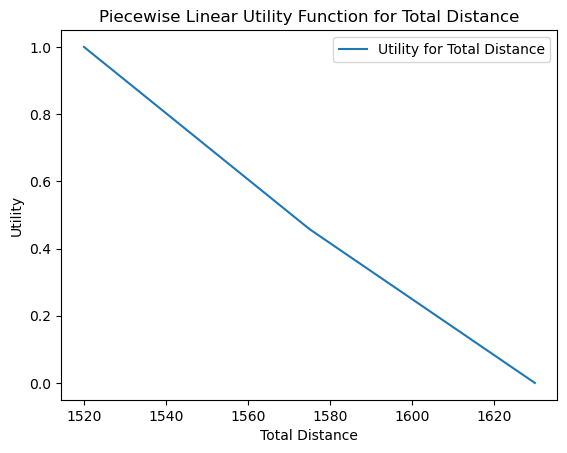

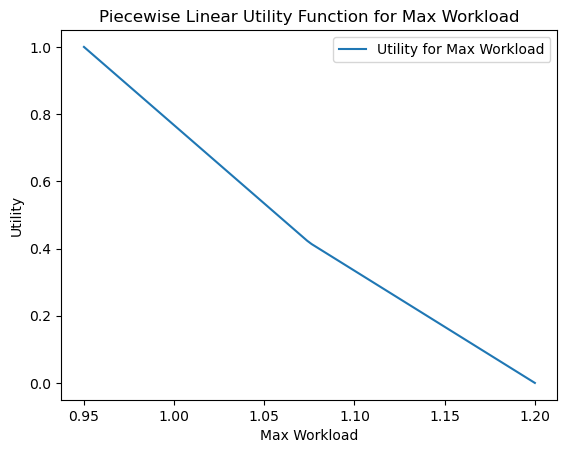

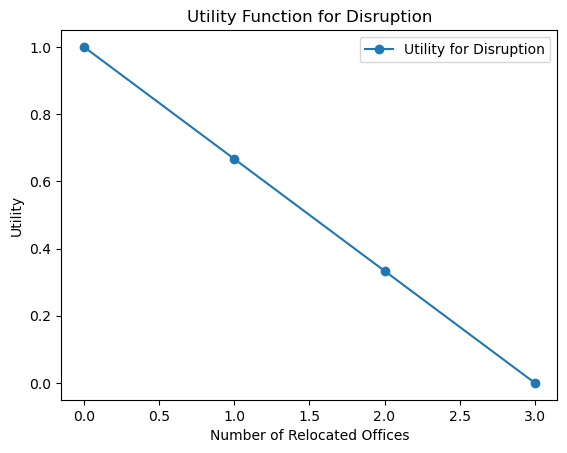

Ranking of non-dominated solutions based on the UTA additive preference model:
Format: (Total Distance, Max Workload, Disruption) -> Overall Utility
  (1520, 1.0, 0) -> 0.9223
  (1535, 1.05, 0) -> 0.7954
  (1570, 0.95, 1) -> 0.7246
  (1550, 1.1, 1) -> 0.5683
  (1590, 1.0, 2) -> 0.4778
  (1610, 1.15, 2) -> 0.2223
  (1630, 1.2, 3) -> 0.0000


In [9]:
"""
UTA-based additive preference model for a three-criteria assignment-relocation problem.

Criteria:
  - c1: Total travel distance (to be minimized)
  - c2: Maximum workload (fairness measure, to be minimized)
  - c3: Number of relocated offices (disruption, to be minimized)

We assume that a set of non-dominated solutions has been computed.
Each solution is represented as a tuple: (total_distance, max_workload, disruption)
where disruption is an integer in [0, number_of_SR].

This script simulates the decision maker’s preferences by randomly generating
piecewise linear utility functions for each criterion and then aggregates
them additively (here with equal weights) to rank the alternatives.
"""

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. SIMULATED NON-DOMINATED SOLUTIONS
# -------------------------------
# (In practice, these would come from the epsilon–constraint procedure.)
# For demonstration purposes we simulate a list of non-dominated solutions.
# Each solution is a tuple: (total_distance, max_workload, disruption)
non_dominated = [
    (1520, 1.00, 0),
    (1535, 1.05, 0),
    (1550, 1.10, 1),
    (1570, 0.95, 1),
    (1590, 1.00, 2),
    (1610, 1.15, 2),
    (1630, 1.20, 3)
]

# Extract arrays of criterion values:
z1_vals = np.array([sol[0] for sol in non_dominated])  # total distance
T_vals  = np.array([sol[1] for sol in non_dominated])  # max workload
D_vals  = np.array([sol[2] for sol in non_dominated])  # disruption

# -------------------------------
# 2. DEFINE PIECEWISE LINEAR UTILITY FUNCTIONS
# -------------------------------
# For cost criteria, lower values are better. We normalize so that:
#   - At the best performance (minimum value) the utility = 1.
#   - At the worst performance (maximum value) the utility = 0.
# We define a three-segment piecewise linear function with breakpoints at:
#   x0 = minimum, x1 = midpoint, x2 = maximum.
#
# We simulate the decision maker’s shape by choosing the utility at the midpoint
# randomly (subject to 0 < u_mid < 1).

def create_piecewise_utility(domain_min, domain_max):
    """Return a utility function u(x) defined on [domain_min, domain_max].
       u(domain_min)=1, u(domain_max)=0, and u(mid)=u_mid (randomly chosen)."""
    mid = (domain_min + domain_max) / 2.0
    u_mid = np.random.uniform(0.3, 0.7)  # simulated DM value at the midpoint
    
    def u(x):
        if x <= domain_min:
            return 1.0
        elif x >= domain_max:
            return 0.0
        elif x <= mid:
            # Linear interpolation between (domain_min,1) and (mid, u_mid)
            return 1.0 - (1.0 - u_mid) * ((x - domain_min) / (mid - domain_min))
        else:
            # Linear interpolation between (mid, u_mid) and (domain_max,0)
            return u_mid - u_mid * ((x - mid) / (domain_max - mid))
    return u, u_mid

# For each criterion, compute the domain from the non-dominated solutions.
z1_min, z1_max = z1_vals.min(), z1_vals.max()
T_min,  T_max  = T_vals.min(), T_vals.max()
D_min,  D_max  = D_vals.min(), D_vals.max()  # Disruption is discrete

# Create utility functions for each criterion.
u1, u1_mid = create_piecewise_utility(z1_min, z1_max)  # for total distance
u2, u2_mid = create_piecewise_utility(T_min, T_max)     # for max workload

# For disruption (c3), since there are only a few integer values, we define a simple piecewise function.
# We use the same idea: u(D_min)=1 and u(D_max)=0.
def u3(x):
    if x <= D_min:
        return 1.0
    elif x >= D_max:
        return 0.0
    else:
        # Linear interpolation between D_min and D_max.
        return 1.0 - (x - D_min) / (D_max - D_min)

# -------------------------------
# 3. PLOT THE UTILITY FUNCTIONS (OPTIONAL)
# -------------------------------
# Plot utility for total distance:
x_range = np.linspace(z1_min, z1_max, 100)
plt.figure()
plt.plot(x_range, [u1(x) for x in x_range], label="Utility for Total Distance")
plt.xlabel("Total Distance")
plt.ylabel("Utility")
plt.title("Piecewise Linear Utility Function for Total Distance")
plt.legend()
plt.show()

# Plot utility for max workload:
x_range2 = np.linspace(T_min, T_max, 100)
plt.figure()
plt.plot(x_range2, [u2(x) for x in x_range2], label="Utility for Max Workload")
plt.xlabel("Max Workload")
plt.ylabel("Utility")
plt.title("Piecewise Linear Utility Function for Max Workload")
plt.legend()
plt.show()

# Plot utility for disruption (discrete values)
x_range3 = np.arange(D_min, D_max + 1)
u3_vals = [u3(x) for x in x_range3]
plt.figure()
plt.plot(x_range3, u3_vals, 'o-', label="Utility for Disruption")
plt.xlabel("Number of Relocated Offices")
plt.ylabel("Utility")
plt.title("Utility Function for Disruption")
plt.legend()
plt.show()

# -------------------------------
# 4. COMPUTE OVERALL UTILITY FOR EACH ALTERNATIVE
# -------------------------------
# We assume an additive value function:
#    U(a) = w1 * u1(c1) + w2 * u2(c2) + w3 * u3(c3)
# For simplicity we use equal weights.
w1 = w2 = w3 = 1/3

overall_utilities = []
for sol in non_dominated:
    z1_val, T_val, D_val = sol
    util = w1 * u1(z1_val) + w2 * u2(T_val) + w3 * u3(D_val)
    overall_utilities.append(util)

# -------------------------------
# 5. RANK THE ALTERNATIVES AND SUPPORT THE DECISION
# -------------------------------
# Higher overall utility is better.
ranking = sorted(zip(non_dominated, overall_utilities), key=lambda x: x[1], reverse=True)

print("Ranking of non-dominated solutions based on the UTA additive preference model:")
print("Format: (Total Distance, Max Workload, Disruption) -> Overall Utility")
for sol, util in ranking:
    print("  {} -> {:.4f}".format(sol, util))
